In [1]:
# Copyright (c) 2020 Urbain Vaes. All rights reserved.
#
# This work is licensed under the terms of the MIT license.
# For a copy, see <https://opensource.org/licenses/MIT>.
import numpy as np
import scipy.stats
import scipy.integrate
import scipy.optimize
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
matplotlib.rc('font', size=20)
matplotlib.rc('font', family='serif')
matplotlib.rc('figure', figsize=(16, 11))
matplotlib.rc('lines', linewidth=2)
matplotlib.rc('lines', markersize=12)
matplotlib.rc('figure.subplot', hspace=.3)
matplotlib.rc('figure.subplot', wspace=.1)
matplotlib.rc('animation', html='html5')
np.random.seed(0)

# Inferring the diffusion coefficient
We illustrate the method seen in class for the simplest possible SDE with constant diffusion:
$$
\newcommand{\d}{\mathrm d}
\d X_t = \sigma \, \d W_t, \qquad X_0 = 0.
$$

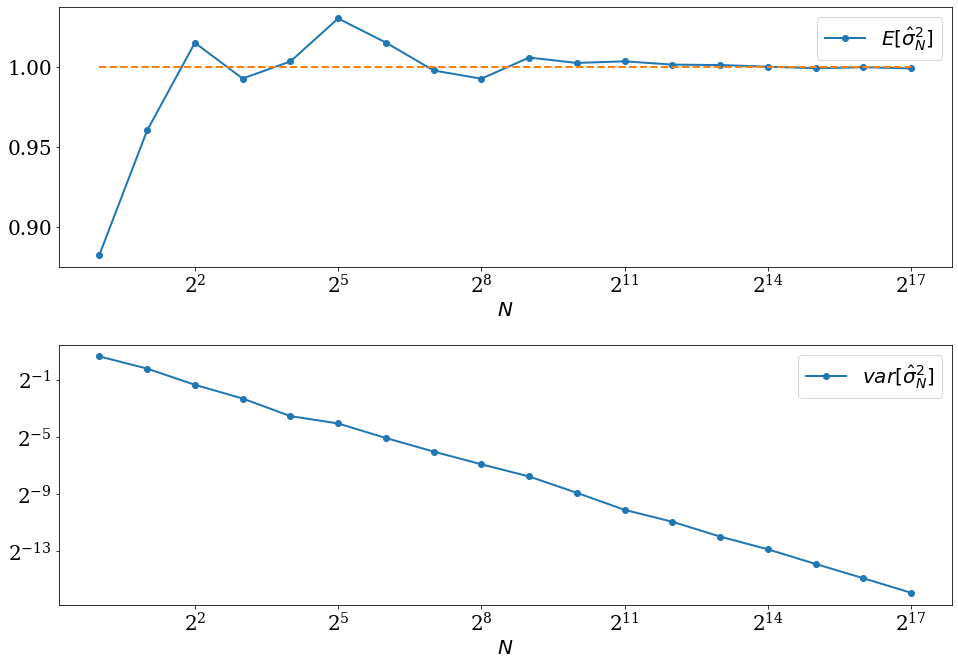

In [3]:
# True diffusion
σ = 1

# Final time
T = 1

# Finest grid points on which we will evaluate X
max_pow = 17
n = 2**max_pow
t = np.linspace(0, T, n + 1)

def estimator(N, x):
    # Check n is a multiple of N
    assert (n % N) == 0

    # Evaluate X on a grid of N points
    k = n // N
    x_N = x[np.arange(0, n + 1, k)]

    # Calculate quadratic variation based on grid
    qv = np.sum(np.diff(x_N)**2)

    # Return estimator
    return qv/T

Ns = 2**np.arange(max_pow + 1)

# Number of replicas
M = 100

estimators = np.zeros((M, len(Ns)))
for i in range(M):
    # Brownian increments and solution
    dw = np.sqrt(T/n) * np.random.randn(n)

    # Solution on the grid t
    x =  np.array([0, *np.cumsum(dw)])

    # Estimate the diffusion coefficient based on the realization x
    estimators[i] = [estimator(N, x) for N in Ns]

mean = np.mean(estimators, axis=0)
variance = np.var(estimators, axis=0)

fig, [ax1, ax2] = plt.subplots(2)
ax1.set_xlabel('$N$')
ax1.set_xscale('log', basex=2)
ax1.plot(Ns, mean, marker='.', label='$E [\hat \sigma^2_N]$')
ax1.plot(Ns, 0*Ns + σ**2, ls='--')
ax1.legend()
ax2.set_xlabel('$N$')
ax2.set_xscale('log', basex=2)
ax2.set_yscale('log', basey=2)
ax2.plot(Ns, variance, marker='.',
         label='$var[ \hat \sigma^2_N]$')
ax2.legend()
plt.show()

# Inferring the drift coefficient
Let us first discuss inference of the drift coefficient for the simple equation
$$
\d X_t = b \, \d t + \d W_t, \qquad X_0 = 0. \tag{1}
$$
In this case the density of the law $\mathbb P_X$ of $X ;= \{X_t\}_{t \in [0, T]}$ w.r.t. the law $\mathbb P_W$ of Brownian motion,
both seen as measures on the space of continuous functions on $[0, T]$,
is given by Girsanov's theorem:
$$
\frac{\d \mathbb P_X}{\d \mathbb P_W} (X; b) = \exp \left(\int_0^T b \, \d X_t - \frac12 \int_0^T b^2 \, \d t \right)
          = \exp \left(b \, X_T - \frac{1}{2} b^2 \, T \right).
$$
This density is called the *likelihood*.
In measure-theoretic terms, the likelihood is the [Radon-Nikodym derivative](https://en.wikipedia.org/wiki/Radon%E2%80%93Nikodym_theorem) of
$\mathbb P_X$ with respect to $\mathbb P_W$.
When we say that $\d \mathbb P_X/\d \mathbb P_W$ is the density of $\mathbb P_X$ with respect to $\mathbb P_W$,
what is meant is that, for any sufficiently well-behaved functional $g$ on $C([0, T])$,
$$
    \mathbb E_{X\sim\mathbb P_X} [g(X)] =  \int g \, \d \mathbb P_X
    = \int g \, \frac{\d \mathbb P_X}{\d \mathbb P_W} \, \d \mathbb P_W
    = \mathbb E_{W \sim \mathbb P_W} \left[g(W)  \frac{\d \mathbb P_X}{\d \mathbb P_W}(W; b)\right]
$$
You may wonder whether there is a reason for calculating the density w.r.t. the law of Browian motion rather than
w.r.t. another probability measure on $C([D, T])$ that is also *equivalent* to the law of $X$?

It turns out that the choice of the measure with respect to which we write the density of the law of $X$ does not matter:
the maximum likelihood estimation would produce the same estimator if we used the density w.r.t. the law of $Y_t = W_t + t$,
for example. Convince yourself of this!

Calculating the density w.r.t. the law of Brownian motion is however convenient,
because the density is given directly by Girsanov's theorem.
We emphasize again that there is no analogue of Lebesgue measure on an infinite-dimensional Banach spaces,
which is the reason why we need to write the density w.r.t. another measure in the first place.

The maximum likelihood estimator is the parameter $b$ that maximimizes the likelihood $\frac{\d \mathbb P_X}{\d \mathbb P_W}(X; b)$,
where $X$ is a given observation.
In the case under consideration, maximization produces the estimator
$$
    \hat b = X_T/T.
$$
This estimator happens to be unbiased, but this is usually not the case in more realistic situations.
Note that, unlike inference for the diffusion coefficient,
where we could obtain an estimation that is arbitrarily precise if we have access to the solution at every $t \in [0, T]$,
the only way to drive the variance of the maximum likelihood estimator for the drift to zero is to obtain more replicas or to consider $T \to \infty$.

Suppose that $X^{(1)}, \dotsc, X^{(J)}$ independently drawn from $\mathbb P_X$:
by this, we mean that $X^{(1)}, \dotsc, X^{(J)}$ are i.i.d. random variables (living in a function space) whose law coincides with that of  the strong solution to $(1)$.
The vector $(X^{(1)}, \dotsc, X^{(J)})$ defines a random variable on the space $C([0, T]) \times \dotsc \times C([0, T])$,
whose density with respect to $\mathbb P_W \times \dotsc \times \mathbb P_W$ is given by
$$
M_T(X^{(1)}, \dotsc, X^{(J)}; b)
= \exp \left(\int_0^T b \, \d X_t^{(1)} - \frac12 \int_0^T b^2 \, \d t \right) \times \dotsc \times \exp \left(\int_0^T b \, \d X_t^{(J)} - \frac12 \int_0^T b^2 \, \d t \right)
$$
Maximizing the likelihood w.r.t. $b$ produces the estimator
$$
\hat b = \frac{1}{J} \sum_{j=1}^J X^{(j)}_T.
$$
which is also unbiased and has variance $\mathrm{var}[X^{(0)}_T]/J$.

## A More interesting example
Now we consider the Euler-Maruyama discretization of the Ornstein-Uhlenbeck process,
which we will view as simply a discrete-time stochastic process:
$$
X_{n+1} = X_{n} - \alpha \, X_{n} \, \Delta t + \xi \, \sqrt{\Delta t}, \qquad \Delta t = .01, \qquad \xi \sim \mathcal N(0, 1), \qquad X_0 = 0, \qquad 0 \leq n \leq N.
$$
Our goal will be, based on a realization of this discrete-time process,
to estimate the parameter $\alpha$.
As we saw on several occasions, the PDF (i.e. the density of the law w.r.t. the Lebesgue measure) of $X := (X_1, \dotsc, X_N)$ is given by
$$
f_X^N(x_1, \dotsc, x_N; \alpha) =
\left|\frac{1}{\sqrt{2\pi\Delta t}}\right|^N \, \exp \left(-\frac{1}{2\Delta t} \sum_{k=0}^{N -1} \left|x_{k+1} - x_{k} + \alpha \, x_k \Delta t \right|^2 \right).
$$
This is maximized when
$$
0 = \frac{\d}{\d \alpha} \sum_{k=0}^{N -1} \left|x_{k+1} - x_{k} + \alpha \, x_k \Delta t \right|^2
= 2 \sum_{k=0}^{N -1} x_k(x_{k+1} - x_{k}) + \alpha \, |x_k|^2 \Delta t,
$$
which gives the MLE estimator
$$
\hat \alpha_N = - \frac{\sum_{k=0}^{N-1} X_K(X_{K+1} - X_K )} {\Delta t \sum_{k=0}^{N-1} |X_k|^2}.
$$

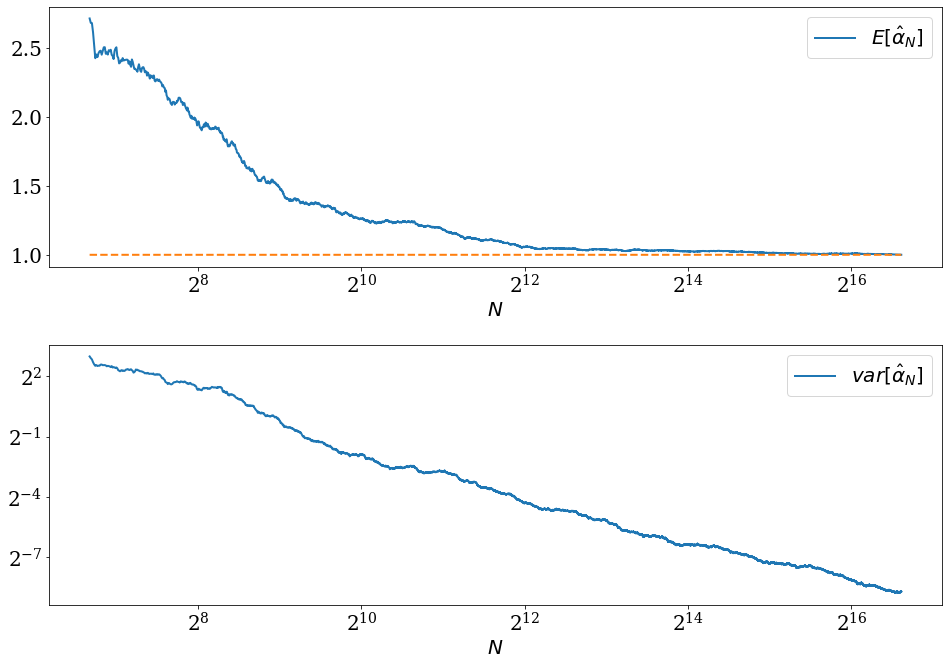

In [4]:
Δt = 0.01
x0 = 0
α = 1

def ou_trajectory(M, N):
    x = np.zeros((N + 1, M))
    ξ = np.random.randn(N, M)
    x[0] = x0
    for i in range(N):
        x[i+1] = x[i] - α * Δt * x[i] + np.sqrt(Δt) * ξ[i]
    return x

# Calculate estimator
M, N = 10**2, 10**5
x = ou_trajectory(M, N)
dx = np.diff(x, axis=0)
num = np.cumsum(x[1:-1]*dx[1:], axis=0)
denom = np.cumsum(x[1:-1]**2, axis=0)
estimator = - (1/Δt) * num / denom

mean = np.mean(estimator, axis=1)
variance = np.var(estimator, axis=1)
Ns = np.arange(2, N + 1)

cutoff = 100
fig, [ax1, ax2] = plt.subplots(2)
ax1.set_xlabel('$N$')
ax1.set_xscale('log', basex=2)
ax1.plot(Ns[cutoff:], mean[cutoff:], label=r"$E [\hat \alpha_N]$")
ax1.plot(Ns[cutoff:], 0*Ns[cutoff:] + α, ls='--')
ax1.legend()
ax2.set_xlabel('$N$')
ax2.set_xscale('log', basex=2)
ax2.set_yscale('log', basey=2)
ax2.plot(Ns[cutoff:], variance[cutoff:],
         label=r"$var[\hat \alpha_N]$")
ax2.legend()
plt.show()

# Introduction to the Bayesian approach
Bayesian inference for the drift coefficient is explored in the assessed coursework,
and here we present only a simple example of Bayesian inference for an unrelated toy problem.
Assume that $\mathbf X = (X^{(1)}, \dots, X^{(J)})$ are i.i.d. real-valued random variables drawn from $\mathcal N(\mu, \sigma^2)$,
where $\mu$ and $\sigma^2$ are parameters to estimate based on this data.
Assume also that we hold a prior belief that $\mu \sim \mathcal N(0, 1)$ and $\sigma^2 \sim U(0, 1)$, independently of $\mu$.
With the Bayesian approach, we view $(\mu, \sigma^2, X^{(1)}, \dots, X^{(J)})$ as a random vector in $\mathbb R^{J+2}$.
Using the notation $\mathbf x = (x^{(1)}, \dots, x^{(J)})$,
the PDF of this random vector is given by
$$
 f_{\mu, \sigma^2, \mathbf X}(m, s^2, \mathbf x)
 = f_{\mu, \sigma^2}(m, s^2) \, f_{\mathbf X | \mu, \sigma^2} (\mathbf x | m, s^2) = g(m; 0, 1) \, I_{[0, 1]}(s^2) \, \prod_{j=1}^{J} g(x^{(j)}; m, s^2),
$$
where $g(x; \alpha, \beta^2)$, for any parameters $\alpha \in \mathbb R$ and $\beta \in \mathbb R_{>0}$, denotes the PDF of $\mathcal N(\alpha, \beta^2)$.
The [conditional distribution](https://en.wikipedia.org/wiki/Conditional_probability_distribution) of $\mu, \sigma^2$ given the data is thus given by:
$$
 f_{\mu, \sigma^2 | \mathbf X}(m, s^2 | \mathbf x)
 = \frac{f_{\mu, \sigma^2, \mathbf X}(m, s^2, \mathbf x)}{f_{\mathbf X}(\mathbf x)}
 = \frac{f_{\mu, \sigma^2, \mathbf X}(m, s^2, \mathbf x)}{\int_{\mathbb R^2} f_{\mu, \sigma^2, \mathbf X}(\mu, \sigma^2, \mathbf x) \, \d \mu \, \d \sigma^2}.
$$
The denominator in this equation is independent of $m$ and $s^2$; it is merely a normalization constant.
Note that the two previous equations can be combined to obtain
$$
  f_{\mathbf X}(\mathbf x) \, f_{\mu, \sigma^2 | \mathbf X}(m, s^2 | \mathbf x)  = f_{\mu, \sigma^2}(m, s^2) \, f_{\mathbf X | \mu, \sigma^2} (\mathbf x | m, s^2),
$$
which is a continuous version of [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem).
This equation is sometimes used as a starting point in order to find the expression of $f_{\mu, \sigma^2| \mathbf X}$.
For the problem under consideration,
$$
 f_{\mu, \sigma^2 | \mathbf X}(m, s^2 | \mathbf x)
 = \frac{g(m; 0, 1) \, I_{[0, 1]}(s^2) \, \prod_{j=1}^{J} g(x^{(j)}; m, s^2)}{\int_{\mathbb R^2} g(\mu; 0, 1) \, I_{[0, 1]}(\sigma^2) \, \prod_{j=1}^{J} g(x^{(j)}; \mu, \sigma^2) \, \d \mu \, \d \sigma^2}.
$$
As mentioned above, the denominator is independent of $\mu$ and $\sigma^2$.
Usually, if one wishes to do uncertainty quantification,
the output of the Bayesian inference is simply the conditional distribution evaluated at the data, $f_{\mu, \sigma^2 | \mathbf X}$.
This distribution, a PDF on the state-space of the unknown parameters,
is called *Bayesian posterior*. A few remarks are in order:

- In general, it is not always possible to calculate the normalization constant (denominator) explicitly,
  although this could be achieved by a simple 2-dimensional quadrature in this simple examlpe.

- The Bayesian posterior can be employed to define a point estimator (i.e. just one value)
  obtained as the pointwise maximizer of the posterior distribution — this is the *maximum a posteriori estimator* (MAP).
  Calculating the MAP does not require the calculation of the normalization constant:
$$
(\hat \mu, \hat \sigma^2)_{MAP} := \mathrm{arg}\max_{\mu, \sigma^2} f_{\mu, \sigma^2}(m, s^2) \, f_{\mathbf X | \mu, \sigma^2} (\mathbf x | m, s^2).
$$
  Notice that the MAP coincides with the MLE in the case of a uniform prior (the prior here is $f_{\mu, \sigma^2}$) over $\Theta$,
  the space of admissible parameters in the general definition of the MLE.

- A large value of $J$ corresponds to a narrow posterior distribution
  and a low influence of the prior distribution.

In [5]:
# Fix seed
np.random.seed(0)

# Number of observations
J = 100

# True value of the parameters
μ, σ = 1, np.sqrt(.4)

# Observations
X = μ + σ * np.random.randn(J)

# Parameters space for the plot
n = 300
μ_min, μ_max = -2, 3
σ2_min, σ2_max = .05, 1.1
μs = np.linspace(μ_min, μ_max, n)
σ2s = np.linspace(σ2_min, σ2_max, n)
μs, σ2s = np.meshgrid(μs, σ2s)

# Prior density
prior = lambda μ, σ2: 1/np.sqrt(2*np.pi) * np.exp(- μ**2 /2) * (σ2 >= 0) * (σ2 <= 1)

# Likelihood evaluated at the first K data
def likelihood(μ, σ2, K):
    result = 1
    for j in range(K):
        result *= 1/np.sqrt(2*np.pi*abs(σ2)) * np.exp(- (X[j] - μ)**2 /σ2/2)
    return result


# Non-normalized posterior distribution based on the frist K data
posterior = lambda μ, σ2, K: prior(μ, σ2) * likelihood(μ, σ2, K)

def plot(K):
    ax.clear()

    # Posterior distribution
    ax.contourf(μs, σ2s, posterior(μs, σ2s, K), levels=20)

    # True value
    ax.scatter(μ, σ**2, label='True value')

    map_estimator = scipy.optimize.fmin(lambda v: - posterior(v[0], v[1], K), [μ, σ**2], disp=False)
    ax.scatter(map_estimator[0], map_estimator[1], label='MAP')

    if K > 0:
        mle_estimator = scipy.optimize.fmin(lambda v: - likelihood(v[0], v[1], K), [μ, σ**2], disp=False)
        ax.scatter(mle_estimator[0], mle_estimator[1], label='MLE')

    ax.set_title("$K = {}$".format(K))
    ax.set_xlabel(r"$\mu$")
    ax.set_ylabel(r"$\sigma^2$")
    ax.legend()

# Create animation
matplotlib.rc('figure', figsize=(12, 8))
fig, ax = plt.subplots()
fig.subplots_adjust(left=.1, bottom=.1, right=.98, top=.95)
anim = animation.FuncAnimation(fig, plot, np.arange(2, J, 2),
                               init_func=lambda: None, repeat=True)

# For Python
# plt.show()

# For the Jupyter notebook
plt.close(fig)
anim